In [1]:
import xarray as xr
import matplotlib.pylab as plt
import numpy as np
import pandas as pd
import intake

#each of the 3IFS runs (2.8km.4km,9km) is stored in one zarr
ifs2_ds=xr.open_zarr('/work/bm1235/a270046/cycle2-sync/ddh_output/2.8km')
ifs4_ds=xr.open_zarr('/work/bm1235/a270046/cycle2-sync/ddh_output/4km')
ifs9_ds=xr.open_zarr('/work/bm1235/a270046/cycle2-sync/ddh_output/9km')

In [2]:
#find ICON high-frequency data
catalog_file = "/work/ka1081/Catalogs/dyamond-nextgems.json"
cat = intake.open_esm_datastore(catalog_file)
hits = cat.search(project="nextGEMS", experiment_id="nextgems_cycle2", frequency=["2minute", "3minute"])
dataset_dict = hits.to_dataset_dict(cdf_kwargs={"chunks": {"time": 1}})
keys = list(dataset_dict.keys())
keys


--> The keys in the returned dictionary of datasets are constructed as follows:
	'project.institution_id.source_id.experiment_id.simulation_id.realm.frequency.time_reduction.grid_label.level_type'


['nextGEMS.MPI-M.ICON-ESM.nextgems_cycle2.ngc2009.atm.2minute.inst.stations.ml',
 'nextGEMS.MPI-M.ICON-ESM.nextgems_cycle2.ngc2012.atm.3minute.inst.stations.ml']

In [3]:
ifs2_ds.station_name.values

array(['BARBADOS CLOUD OBSERVATORY', 'EUREC4A_1', 'EUREC4A_2',
       'EUREC4A_3', 'EUREC4A_4', 'EUREC4A_5', 'EUREC4A_6', 'EUREC4A_7',
       'EUREC4A_8', 'EUREC4A_9', 'EUREC4A_10', 'CABAUW_NL',
       'SODANKYLA_FIN', 'ARMS_OKL', 'LINDENBERG_GER', 'BARROW_USA',
       'SUMMIT_DNK', 'DOMEC_ANTARC', 'PAYERNE_SWZ', 'ATTO_BRZ',
       'MNSGERAIS_BRZ', 'BAHIA_BRZ', 'SAN_LUIS_MXC', 'ZACATECAS_MXC',
       'SCOTLAND', 'BURGOS_SPN', 'HUELVA_SPN', 'PSTERN_SPRING',
       'PSTERN_AUTUMN', 'PSTERN_MARCH'], dtype='<U26')

In [4]:
icon5_ds = dataset_dict[keys[0]]
icon10_ds = dataset_dict[keys[1]]
icon5_ds.station.values

array(['EUREC4A 01', 'EUREC4A 02', 'EUREC4A 03', 'EUREC4A 04',
       'EUREC4A 05', 'EUREC4A 06', 'EUREC4A 07', 'EUREC4A 08',
       'EUREC4A 09', 'EUREC4A 10', 'EUREC4A 11', 'Lindenberg', 'Cabauw',
       'Sodankyla Finland', 'ARMS OKL', 'Barrow Alaska',
       'Summit Greenland', 'Dome C Antarctica', 'Payerne Switzerland',
       'ATTO', 'IBER Minas Gerais/rad', 'IBER Bahia/wind',
       'IBER San Luis Potosi Mex/wind', 'IBER Zacatecas Mex/rad',
       'IBER Scotland/wind', 'IBER Burgos/wind', 'IBER Huelva/rad',
       'MOSAIC Polarstern in spring (warm spells)',
       'MOSAIC Polarstern in autumn (rain event)',
       'MOSAIC Maximal ice production event in March', 'E2S OLDON (MET)',
       'E2S OLUOL (MET)', 'E2S OLCLO (MET)', 'E2S OLETZ (ASI)',
       'E2S BAZWI (ASI)', 'E2S OLEMS (ASI)', 'E2S EMSTE (ASI)',
       'E2S PVRAS (ASI)', 'E2S VAREL (ASI)', 'E2S ESENS (ASI)',
       'E2S AURIC (ASI)', 'E2S DOERP (ASI)', 'E2S BARSE (ASI)',
       'E2S SOEGE (ASI)', 'E2S OLJET (MET)', 'E

In [5]:
#to find out station id for IFS
def find_station_id(s_name):
    station_id = ifs2_ds.station[np.argwhere(ifs2_ds.station_name.values == s_name)[0][0]]
    
    return station_id

In [6]:
#to find out level for ICON
def find_nearest_id(z_ifc, value):
    z_ifc = np.asarray(z_ifc)
    idx = (np.abs(z_ifc - value)).argmin()
    print(z_ifc[idx])
    return idx

#calculate horzontal wind speed
def cal_wdsp(ds_in):
    return np.sqrt(ds_in.u**2 + ds_in.v**2)

In [10]:
icon_station = 'Lindenberg'
ifs_station = 'LINDENBERG_GER'
#ifs
station_id = find_station_id(ifs_station)

ifs2_station = cal_wdsp(ifs2_ds.sel(station=station_id).isel(level=-4)).resample(time='D').mean('time')
ifs4_station = cal_wdsp(ifs4_ds.sel(station=station_id).isel(level=-4)).resample(time='D').mean('time')
ifs9_station = cal_wdsp(ifs9_ds.sel(station=station_id).isel(level=-4)).resample(time='D').mean('time')

#ICON
lev_ind = find_nearest_id(icon5_ds['level_height'].sel(station=icon_station), 100)

icon5_station = cal_wdsp(icon5_ds.sel(station=icon_station).isel(level=lev_ind)).resample(time='D').mean('time')
icon10_station = cal_wdsp(icon10_ds.sel(station=icon_station).isel(level=lev_ind)).resample(time='D').mean('time')

86.07225799560547


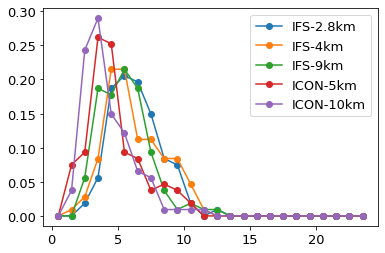

In [13]:
plt.rcParams.update({'font.size': 13})

hist_2, bin_edges = np.histogram(ifs2_station.sel(time=slice('2020-02-22', '2020-06-07')), bins=np.arange(0,25,1), density=True)
hist_4, bin_edges = np.histogram(ifs4_station.sel(time=slice('2020-02-22', '2020-06-07')), bins=np.arange(0,25,1), density=True)
hist_9, bin_edges = np.histogram(ifs9_station.sel(time=slice('2020-02-22', '2020-06-07')), bins=np.arange(0,25,1), density=True)
hist_5, bin_edges = np.histogram(icon5_station.sel(time=slice('2020-02-22', '2020-06-07')), bins=np.arange(0,25,1), density=True)
hist_10, bin_edges = np.histogram(icon10_station.sel(time=slice('2020-02-22', '2020-06-07')), bins=np.arange(0,25,1), density=True)

bins= 0.5*(bin_edges[1:] + bin_edges[:-1])

plt.plot( bins, hist_2, '-o',label='IFS-2.8km')
plt.plot( bins, hist_4, '-o',label='IFS-4km')
plt.plot( bins, hist_9, '-o',label='IFS-9km')
plt.plot( bins, hist_5, '-o',label='ICON-5km')
plt.plot( bins, hist_10, '-o',label='ICON-10km')

plt.legend()